In [1]:
import numpy as np
from pymatgen.core import Structure
from chgnet.model import CHGNet
import torch

## 1. Prepare Testing Data


In [2]:
from collections import defaultdict
from chgnet.utils import read_json
from pymatgen.core.structure import Structure

sources = ["chgnet_dataset_dhh_I-42d.json", "chgnet_dataset_dhh_with_stresses.json"]

merged = defaultdict(list)

for s in sources:
    d = read_json(s)
    for k, v in d.items():
        if isinstance(v, list):
            merged[k].extend(v)
        else:
            merged[k].append(v)

dataset_dict = dict(merged)

structures = [Structure.from_dict(struct) for struct in dataset_dict["structure"]]
energies_per_atom = dataset_dict["energy_per_atom"]
forces = dataset_dict["force"]
stresses = dataset_dict.get("stress") or None
magmoms = None

print(len(structures))

615


## 2. Define DataSet


In [3]:
from chgnet.data.dataset import StructureData
from torch.utils.data import DataLoader, SubsetRandomSampler

In [4]:
dataset = StructureData(
    structures=structures,
    energies=energies_per_atom,
    forces=forces,
    stresses=stresses,  # can be None
    magmoms=magmoms,  # can be None
)

data = np.load("dhh_split_indices.npz")
train_idx = data["train_idx"]
val_idx   = data["val_idx"]
test_idx  = data["test_idx"]

train_loader = DataLoader(
    dataset,
    batch_size=8,
    sampler=SubsetRandomSampler(train_idx),
)
val_loader = DataLoader(
    dataset,
    batch_size=8,
    sampler=SubsetRandomSampler(val_idx),
)
test_loader = DataLoader(
    dataset,
    batch_size=8,
    sampler=SubsetRandomSampler(test_idx),
)

StructureData imported 615 structures


## 3. Load models


In [5]:
from chgnet.model import CHGNet

base_chgnet = CHGNet.load(model_name="r2scan")

ckpt_path = "/home/phy_cmp/python_projects/CHGnet/12-11-2025/epoch18_e126_f60_s529_mNA.pth.tar"
checkpoint = torch.load(ckpt_path, map_location="cpu")

model_blob = checkpoint["model"]

state_dict = model_blob["state_dict"]

fine_tuned_chgnet = CHGNet.load(model_name="r2scan")
fine_tuned_chgnet.load_state_dict(state_dict)

device = "cpu"  # или "cuda"
base_chgnet.to(device).eval()
fine_tuned_chgnet.to(device).eval()


CHGNet vr2scan initialized with 412,525 parameters
CHGNet will run on cpu
CHGNet vr2scan initialized with 412,525 parameters
CHGNet will run on cpu


CHGNet(
  (composition_model): AtomRef(
    (fc): Linear(in_features=94, out_features=1, bias=False)
  )
  (graph_converter): CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3)
  (atom_embedding): AtomEmbedding(
    (embedding): Embedding(94, 64)
  )
  (bond_basis_expansion): BondEncoder(
    (rbf_expansion_ag): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
    (rbf_expansion_bg): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
  )
  (bond_embedding): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_ag): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_bg): Linear(in_features=31, out_features=64, bias=False)
  (angle_basis_expansion): AngleEncoder(
    (fourier_expansion): Fourier()
  )
  (angle_embedding): Linear(in_features=31, out_features=64, bias=False)
  (atom_conv_layers): ModuleList(
    (0-3): 4 x AtomConv(
      (activation): SiLU()
      (twoBody_atom): GatedMLP(
        (mlp_c

## 4. Evaluation


In [6]:
def predict(model, structures, indices, property):
    model.eval()
    preds = []

    for i in indices:
        struct = structures[i]
        out = model.predict_structure(struct)
        preds.append(out[f"{property}"])

    return np.array(preds)

In [7]:
def mae_rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    diff = y_pred - y_true
    return float(np.mean(np.abs(diff))), float(np.sqrt(np.mean(diff**2)))

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_error_histogram(
    y_true,
    y_pred_base,
    y_pred_ft,
    scale=1.0,
    xlabel=r"$\Delta$",
    ylabel=r"Density",
    bins=10,
    label_base="Pretrained",
    label_ft="Fine-tuned",
    figsize=(7, 5),
):
    y_true = np.asarray(y_true)
    y_pred_base = np.asarray(y_pred_base)
    y_pred_ft   = np.asarray(y_pred_ft)

    delta_base = (y_true - y_pred_base).ravel() * scale
    delta_ft   = (y_true - y_pred_ft).ravel()   * scale

    mu_base = np.mean(delta_base)
    mu_ft   = np.mean(delta_ft)

    fig, ax = plt.subplots(figsize=figsize)

    x_min = min(delta_base.min(), delta_ft.min())
    x_max = max(delta_base.max(), delta_ft.max())

    color_base = "tab:blue"
    color_ft   = "tab:orange"

    ax.hist(
        delta_base,
        bins=bins,
        range=(x_min, x_max),
        density=True,
        alpha=0.3,
        edgecolor="black",
        color=color_base,
        label="_nolegend_",
    )

    ax.hist(
        delta_ft,
        bins=bins,
        range=(x_min, x_max),
        density=True,
        alpha=0.3,
        edgecolor="black",
        color=color_ft,
        label="_nolegend_",
    )

    x = np.linspace(x_min, x_max, 400)

    kde_base = gaussian_kde(delta_base)
    ax.plot(x, kde_base(x), linewidth=2, color=color_base, label=label_base)

    kde_ft = gaussian_kde(delta_ft)
    ax.plot(x, kde_ft(x), linewidth=2, linestyle="-", color=color_ft, label=label_ft)

    ax.axvline(mu_base, linestyle="--", linewidth=1.5, color=color_base)
    ax.axvline(mu_ft,   linestyle="--",  linewidth=1.5, color=color_ft)

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

    ax.tick_params(
        axis="x",
        which="both",
        direction="in",
        top=True,
        bottom=True,
        labelsize=16,
    )
    ax.tick_params(
        axis="y",
        which="both",
        direction="in",
        left=True,
        right=True,
        labelleft=False,
    )

    ax.set_xlim(x_min, x_max)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


### 4.1 Energies

In [11]:
energy_pred_base = predict(base_chgnet, structures, test_idx, "e")
energy_pred_ft = predict(fine_tuned_chgnet, structures, test_idx, "e")

energy_true = np.array([energies_per_atom[i] for i in test_idx])

In [12]:
print("=== Энергия (эВ/атом) на test ===")
print(f"Базовая   MAE  = {mae_rmse(energy_true, energy_pred_base)[0]:.4f}, "
      f"RMSE = {mae_rmse(energy_true, energy_pred_base)[1]:.4f}")
print(f"Fine-tune MAE  = {mae_rmse(energy_true, energy_pred_ft)[0]:.4f}, "
      f"RMSE = {mae_rmse(energy_true, energy_pred_ft)[1]:.4f}")

=== Энергия (эВ/атом) на test ===
Базовая   MAE  = 8.3244, RMSE = 10.4315
Fine-tune MAE  = 8.3357, RMSE = 10.4461


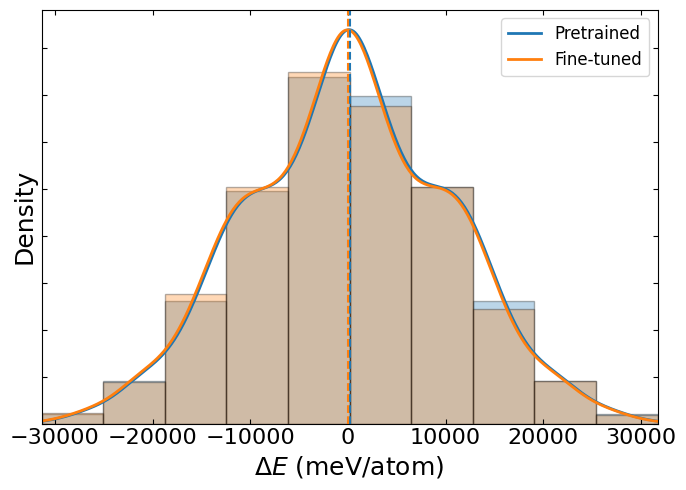

In [13]:
plot_error_histogram(
    y_true=energy_true,
    y_pred_base=energy_pred_base,
    y_pred_ft=energy_pred_ft,
    scale=1e3,
    xlabel=r"$\Delta E$ (meV/atom)",
)

### 4.2 Forces

In [14]:
force_pred_base = predict(base_chgnet, structures, test_idx, "f")
force_pred_ft = predict(fine_tuned_chgnet, structures, test_idx, "f")

force_true = np.array([forces[i] for i in test_idx])

In [15]:
mae_F_base, rmse_F_base  = mae_rmse(force_true, force_pred_base)
mae_F_ft, rmse_F_ft  = mae_rmse(force_true, force_pred_ft)

print("\n=== Силы (эВ/Å) на test ===")
print(f"Базовая   MAE = {mae_F_base:.4f}, RMSE = {rmse_F_base:.4f}")
print(f"Fine-tune MAE = {mae_F_ft:.4f}, RMSE = {rmse_F_ft:.4f}")


=== Силы (эВ/Å) на test ===
Базовая   MAE = 0.0866, RMSE = 0.2580
Fine-tune MAE = 0.0558, RMSE = 0.1428


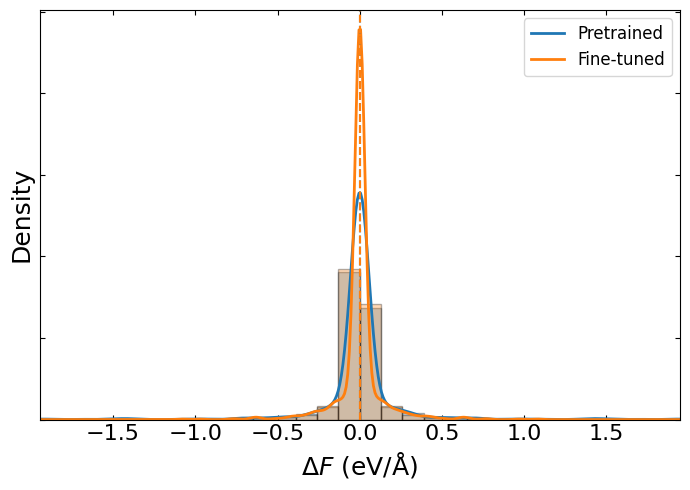

In [16]:
plot_error_histogram(
    y_true=force_true,
    y_pred_base=force_pred_base,
    y_pred_ft=force_pred_ft,
    scale=1.0,
    xlabel=r"$\Delta F$ (eV/$\mathrm{\AA}$)",
    bins=30,
)

### 4.3 Stresses

In [17]:
stress_pred_base = predict(base_chgnet, structures, test_idx, "s")
stress_pred_ft   = predict(fine_tuned_chgnet, structures, test_idx, "s")

stress_true = np.array([stresses[i] for i in test_idx])

In [18]:
mae_stress_base, rmse_stress_base  = mae_rmse(stress_true, stress_pred_base)
mae_stress_ft, rmse_stress_ft  = mae_rmse(stress_true, stress_pred_ft)

print("\n=== Напряжения (GPa) на test ===")
print(f"Базовая   MAE = {mae_stress_base:.4f}, RMSE = {rmse_stress_base:.4f}")
print(f"Fine-tune MAE = {mae_stress_ft:.4f}, RMSE = {rmse_stress_ft:.4f}")


=== Напряжения (GPa) на test ===
Базовая   MAE = 6.7867, RMSE = 16.6551
Fine-tune MAE = 6.7829, RMSE = 16.8243


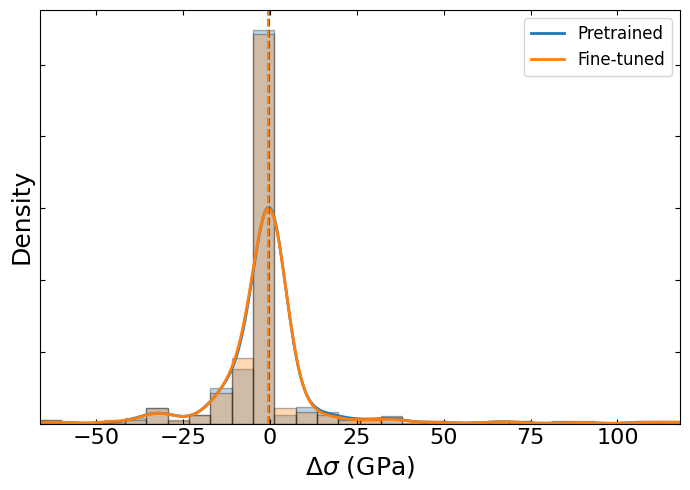

In [19]:
plot_error_histogram(
    y_true=stress_true,
    y_pred_base=stress_pred_base,
    y_pred_ft=stress_pred_ft,
    scale=1.0,
    xlabel=r"$\Delta \sigma$ (GPa)",
    bins=30,
)